# Gene Mutation Classification Model 🧬- Dataset from https://portal.gdc.cancer.gov/analysis_page?app=MutationFrequencyApp&demoMode=true

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [91]:
train_data = pd.read_csv('data/frequently-mutated-genes.2025-03-17.csv')
train_data.drop(columns=['gene_id', 'type', 'annotations'], inplace=True)
train_data.head()

,symbol,name,cytoband,num_cohort_ssm_affected_cases,num_cohort_ssm_cases,cohort_ssm_affected_cases_percentage,num_gdc_ssm_affected_cases,num_gdc_ssm_cases,gdc_ssm_affected_cases_percentage,num_cohort_cnv_cases,num_cohort_cnv_gain_cases,cohort_cnv_gain_cases_percentage,num_cohort_cnv_loss_cases,cohort_cnv_loss_cases_percentage,num_mutations
0,IDH1,isocitrate dehydrogenase (NADP(+)) 1,2q34,394,513,76.80,600,16508,3.63,515,7,1.36,13,2.52,4
1,TP53,tumor protein p53,17p13.1,240,513,46.78,4964,16508,30.07,515,6,1.17,10,1.94,169
2,ATRX,ATRX chromatin remodeler,Xq21.1,187,513,36.45,817,16508,4.95,515,0,0.00,0,0.00,190
3,CIC,capicua transcriptional repressor,19q13.2,110,513,21.44,464,16508,2.81,515,23,4.47,236,45.83,96
4,FUBP1,far upstream element binding protein 1,1p31.1,45,513,8.77,229,16508,1.39,515,12,2.33,183,35.53,42


In [92]:
num_mut = []
names = []
for i in train_data['symbol']:  
    if i == 'IDH2':  
        break
    else:
        num_mut.append(train_data.loc[train_data['symbol'] == i, 'num_mutations'].values[0])
        names.append(train_data.loc[train_data['symbol'] == i, 'symbol'].values[0])
num_mut = np.array(num_mut) 
print(y[:15])

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    0
11    0
12    0
13    0
14    0
Name: high_mutation, dtype: int32


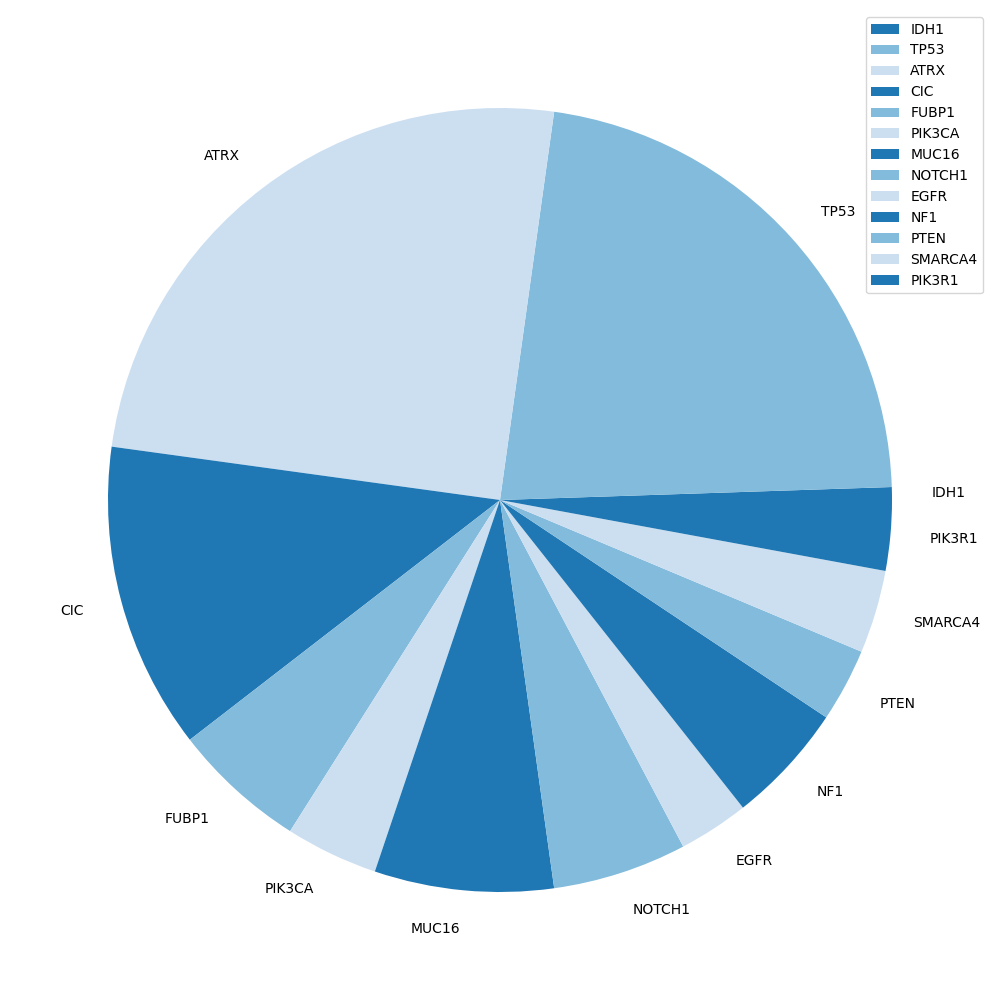

In [93]:
plt.pie(num_mut, labels=names)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.legend()
plt.show()

# Goal: Predict whether a gene is highly mutated (above a certain mutation frequency threshold).
- Target Variable: cohort_ssm_affected_cases_percentage (or any other relevant metric).
- Features: Gene location (cytoband), number of mutations, CNV gains/losses, and affected cases.

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

train_data["high_mutation"] = (train_data["cohort_ssm_affected_cases_percentage"] > 5).astype(int)


features = [
    "num_cohort_ssm_affected_cases", "num_cohort_ssm_cases",
    "num_gdc_ssm_affected_cases", "num_gdc_ssm_cases",
    "num_cohort_cnv_cases", "num_cohort_cnv_gain_cases",
    "cohort_cnv_gain_cases_percentage", "num_cohort_cnv_loss_cases",
    "cohort_cnv_loss_cases_percentage", "num_mutations"
]

X = train_data[features]
y = train_data["high_mutation"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Check class distribution after splitting
y_train.value_counts(), y_test.value_counts()

(high_mutation
 0    560
 1      8
 Name: count, dtype: int64,
 high_mutation
 0    141
 1      2
 Name: count, dtype: int64)

In [95]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight


class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train.to_numpy()), 
    y=y_train.to_numpy()
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid") 
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_test_tensor = tf.convert_to_tensor(y_test)


history = model.fit(
    X_train_tensor, y_train_tensor,
    epochs=50, batch_size=16,
    validation_data=(X_test_tensor, y_test_tensor),
    class_weight=class_weight_dict,
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test_tensor, y_test_tensor)

test_loss, test_acc = model.evaluate(X_test_tensor.numpy(), y_test_tensor.numpy())
test_loss, test_acc 

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9833 - loss: 3.0803 - val_accuracy: 0.9860 - val_loss: 0.4455
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 2.1462 - val_accuracy: 0.9860 - val_loss: 0.3940
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.6043 - val_accuracy: 0.9790 - val_loss: 0.3245
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9809 - loss: 1.1868 - val_accuracy: 0.9790 - val_loss: 0.2658
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 0.7202 - val_accuracy: 0.9790 - val_loss: 0.2153
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9601 - loss: 0.7782 - val_accuracy: 0.9860 - val_loss: 0.1665
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9760 - loss: 0.3250 - val_accuracy: 0.9860 - val_loss: 0.1279
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9836 - loss: 0.2148 - val_accuracy: 0.9860 - val_loss:

(0.020157020539045334, 0.9930070042610168)

In [96]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_probs = model.predict(X_test_tensor.numpy())
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test_tensor.numpy(), y_pred))
print(confusion_matrix(y_test_tensor.numpy(), y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       141
           1       0.67      1.00      0.80         2

    accuracy                           0.99       143
   macro avg       0.83      1.00      0.90       143
weighted avg       1.00      0.99      0.99       143

[[140   1]
 [  0   2]]


# Precision can be better
- i think Precision could be improved by having more data or something but over all the model is pretty good (: